### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [169]:
#!pip install numdifftools

In [170]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import laplace
import corner
import numdifftools as nd

In [171]:
# import numdifftools as nd
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

### Solution

In [172]:
data = np.load('hw_data/hw3_data_1.npy')
x = data[:,0]
sigma = data [:,1]
#data

In [173]:
sample_mu = np.sum(x / sigma**2) / np.sum(1/(sigma**2))
sample_sigma = np.sqrt(1/np.sum((sigma)**2))
print('Sample Mean = ',sample_mu ,'\nStandard Error on the sample mean = ' , sample_sigma)

Sample Mean =  3.9179920346060557 
Standard Error on the sample mean =  0.07698466011059846


## Gaussian Fit

In [174]:
def negative_log_likelihood_gaussian(params, x):
    mu, sigma = params
    return np.sum((x - mu)**2 / (2 * sigma**2) + np.log(np.sqrt(2 * np.pi * sigma**2)))
result = sp.optimize.minimize(negative_log_likelihood_gaussian, [np.mean(x), np.std(x, ddof=1)], args=(x,))
mu_fit_g, sigma_fit_g = result.x
print('After optimization the mean turn out to be = ',mu_fit_g,'sigma = ',sigma_fit_g)

After optimization the mean turn out to be =  3.937547481513503 sigma =  1.1507205811063763


### Fisher Uncertainty for Gaussian Mean

In [175]:
f_mu = 1/np.sqrt(np.sum(1/sigma**2))
print('fischer uncertainity of mu = ',f_mu)

fischer uncertainity of mu =  0.09481084100510956


In [176]:
# bootstrap_data = np.empty((1000, 50, 2))
# np.random.seed(42)
# for j in range(1000):
#     for i in range(50):
#         rnd = np.random.randint(0, 50)
#         bootstrap_data[j,i] = data[rnd]        

### BootStrapping

In [177]:
bootstrapped_datasets_np = [data[np.random.choice(data.shape[0], size=data.shape[0], replace=True)] for _ in range(1000)]

### Gaussian Fit for Bootstrapped Data

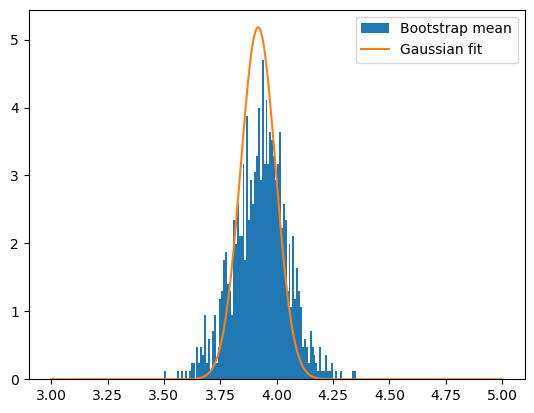

In [178]:
mu_hist_g=[]
for j in range(1000):
    boot_x = bootstrapped_datasets_np[j][:,0]
    boot_sigma = bootstrapped_datasets_np[j][:,1]
    result = sp.optimize.minimize(negative_log_likelihood_gaussian, [np.mean(boot_x), np.std(boot_x, ddof=1)], args=(boot_x,))
    mu_fit, sigma_fit = result.x
    mu_hist_g.append(mu_fit)
    
plt.hist(mu_hist_g, bins=100,density=True, label ='Bootstrap mean')
dist_g = norm(loc=sample_mu, scale=sample_sigma)
x_range = np.linspace(3,5,1000)
plt.plot(x_range,dist_g.pdf(x_range),label='Gaussian fit')
plt.legend()
plt.show()

## Laplace fit

In [179]:
def negative_log_likelihood_laplace(params, x):
    mu, delta = params
    return np.sum(np.log(2 * delta) + np.abs(x - mu) / delta)
res_l = sp.optimize.minimize(negative_log_likelihood_laplace, [np.median(x), np.mean(np.abs(x - np.median(x)))], args=(x,))
mu_fit_l, delta_fit_l = res_l.x

print('After optimization the mean turns out to be = ',mu_fit_l)

After optimization the mean turns out to be =  4.085141264538312


### AIC

In [180]:
def log_likelihood_gaussian(mu, sigma, x):
    return -0.5 * np.sum(((x - mu) / sigma)**2 + np.log(2 * np.pi * sigma**2))

def log_likelihood_laplace(mu, delta, x):
    return -np.sum(np.log(2 * delta) + np.abs(x - mu) / delta)
    
def compute_aic(log_likelihood, k):
    return 2 * k - 2 * log_likelihood
k=2
aic_g = compute_aic(log_likelihood_gaussian(mu_fit_g, sigma_fit_g, x) , k)
aic_l = compute_aic(log_likelihood_laplace(mu_fit_l, delta_fit_l, x) , k)
#log_likelihood_gaussian(mu_fit_g, sigma_fit_g, x) , log_likelihood_laplace(mu_fit_l, delta_fit_l, x)

In [181]:
print('Lower AIC is favoured \nAIC of Gaussian = ',aic_g,'\nAIC of Laplacian = ',aic_l)

Lower AIC is favoured 
AIC of Gaussian =  315.86537847577375 
AIC of Laplacian =  317.57783235318016


### Bootstrap with Laplace fit

In [182]:
hist_l=np.empty((1000,2))
for j in range(1000):
    boot_x = bootstrapped_datasets_np[j][:,0]
    boot_sigma = bootstrapped_datasets_np[j][:,1]
    result = sp.optimize.minimize(negative_log_likelihood_laplace, [np.median(boot_x), np.mean(np.abs(boot_x - np.median(boot_x)))], args=(boot_x,))
    b_mu_fit_l, b_delta_fit_l = result.x
    hist_l[j]=np.array([b_mu_fit_l, b_delta_fit_l])
    
# plt.hist(hist_l[:,0], bins=30,density=True)
# dist_l = laplace(loc=sample_mu, scale=sample_sigma)
# x_range = np.linspace(3,5,1000)
# plt.plot(x_range,dist_l.pdf(x_range))
# plt.show()

## Corner Plot for Mean and Sigma from Bootstrap Laplace Fit

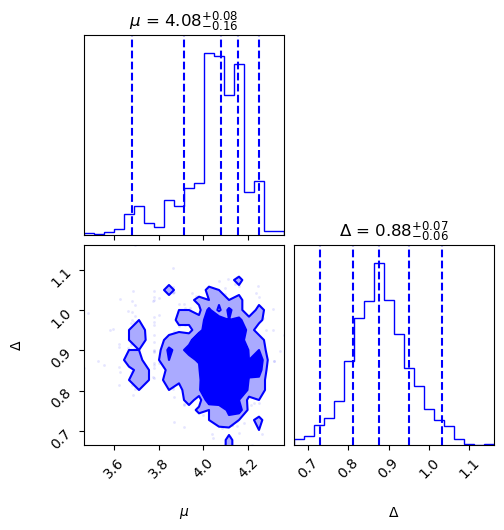

In [183]:

fig = corner.corner(hist_l, 
                    quantiles=[0.16, 0.5, 0.84,0.025,0.975],  
                    show_titles=True,  
                    title_kwargs={"fontsize": 12}, 
                    labels=[r"$\mu$", r"$\Delta$"],
                    color="blue", 
                    fill_contours=True,  
                    levels=[0.68, 0.95],  
                    plot_density=True,  
                    title_quantiles=[0.16, 0.5, 0.84]
)


### Fisher Uncertainties for Laplace Fit

In [184]:
def log_likelihood(params, data):
    mu, delta = params
    return -np.sum(np.log(laplace.pdf(data, loc=mu, scale=delta)))

def compute_hessian(log_likelihood, data, params):
    hessian = nd.Hessian(lambda p: log_likelihood(p, data))(params)
    return hessian

params_best_fit = [mu_fit_l, delta_fit_l]
hessian_matrix = compute_hessian(log_likelihood, x, params_best_fit)

covariance_matrix = np.linalg.inv(hessian_matrix)

fisher_uncertainties = np.sqrt(np.diag(covariance_matrix))

In [185]:
print('Fisher Mean Uncertainity of laplace fit = ', fisher_uncertainties[0])
mu_bootstrap_width = np.std(hist_l[:,0])
print('STD of Mean from Bootstraped laplace fit = ',mu_bootstrap_width)

Fisher Mean Uncertainity of laplace fit =  0.1092248022374498
STD of Mean from Bootstraped laplace fit =  0.1397162178692172


## The spread is more in the bootstraped data

In [186]:
# import numpy as np
# from scipy.stats import norm, laplace

# # Given data (first column is values, second column is uncertainties)
# data_values = np.array([
#     [2.97207735, 0.93806458], [1.98824293, 1.40262692], [1.66981961, 1.97120698],
#     [3.96519709, 0.60359301], [3.38541476, 1.29698654], [4.24894584, 1.68629961],
#     [3.69290063, 1.06277049], [4.33198366, 1.28038671], [2.49401178, 1.22485083],
#     [1.89419429, 1.40555012], [2.04203146, 1.30841409], [4.15394176, 1.97421998],
#     [4.14130534, 1.59510787], [4.21256076, 1.4295954 ], [4.47047556, 0.9776734 ],
#     [4.29385594, 1.47949413], [3.68668822, 0.96958318], [4.67658913, 1.53171867],
#     [3.66326255, 0.51330266], [3.86702391, 0.69561611], [4.15062285, 0.76745015],
#     [5.10972749, 1.94193392], [4.16180633, 1.26347131], [4.04294769, 1.50713396],
#     [3.14447868, 1.51402808], [6.13017327, 1.67982047], [7.47431877, 1.79210525],
#     [4.55226549, 0.70417746], [3.18937552, 1.41750426], [5.05068215, 1.59340252],
#     [2.58504832, 1.40936962], [3.2807617 , 0.7817426 ], [3.15074159, 0.5165563 ],
#     [4.68488632, 0.67327222], [6.58112816, 1.91096086], [2.8891109 , 1.63403368],
#     [5.12723698, 0.58202125], [4.42150207, 0.86437187], [5.78739811, 1.1488919 ],
#     [3.09099302, 0.99063548], [2.95001153, 1.72585217], [4.56778994, 1.07847601],
#     [5.18264257, 0.85565779], [2.84179256, 0.71061225], [4.39262812, 1.76637912],
#     [4.04550675, 0.59957146], [5.61515858, 1.54215483], [4.30454563, 1.09315219],
#     [4.54079173, 0.55998747], [4.6024919 , 0.78480243], [4.22466725, 0.65620631],
#     [3.23519179, 1.05628333], [4.68671169, 1.61054331], [3.52982363, 0.5737954 ],
#     [3.91370395, 1.54376768], [2.45921984, 1.25788577], [4.24447507, 0.5740388 ],
#     [3.14653177, 0.77481835], [5.33943461, 1.56386731], [4.03419177, 0.93585464],
#     [5.29661353, 0.94398386], [1.53762427, 1.73185342], [4.73684358, 1.89022008],
#     [4.39143774, 1.30640142], [4.86001446, 1.54601227], [2.94239726, 1.48436902],
#     [4.77882139, 1.62476338], [2.20043281, 1.00299831], [4.65868995, 0.85911013],
#     [3.06975053, 0.52684871], [4.27078305, 1.32872544], [5.45355937, 1.86199703],
#     [3.58302266, 1.42962684], [6.78259445, 1.37286052], [3.69313217, 1.73866964],
#     [3.8625051 , 0.68447321], [5.04842957, 1.72305337], [2.93330476, 1.56728894],
#     [4.26274594, 0.56023998], [4.09244224, 0.86605321], [3.10229518, 0.64341876],
#     [3.22028372, 1.73707399], [3.67446241, 0.50535491], [3.15810998, 0.51140379],
#     [3.13482852, 1.78621005], [0.41036839, 1.52273128], [3.46562245, 0.88805017],
#     [1.35147524, 1.91348597], [4.94178893, 1.07902421], [5.021566 , 0.66213091],
#     [3.28702062, 1.19433008], [4.81515552, 0.65059471], [4.7044181 , 0.94529203],
#     [2.93012022, 1.46766151], [4.77388898, 1.77940055], [4.07784029, 1.44294596],
#     [4.10135768, 1.93956482], [3.08022213, 1.01228358], [4.53694361, 1.92379373],
#     [3.19879973, 1.05058342]
# ])

# # Extract only the first column (data values)
# x = data_values[:, 0]

# # Gaussian best-fit parameters
# mu_gauss, sigma_gauss = norm.fit(x)

# # Laplace best-fit parameters
# mu_laplace, b_laplace = laplace.fit(x)

# print(f"Gaussian Fit: Mean = {mu_gauss:.3f}, Std Dev = {sigma_gauss:.3f}")
# print(f"Laplace Fit: Median = {mu_laplace:.3f}, Scale = {b_laplace:.3f}")


In [187]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm, laplace

# # Extract only the first column (data values)
# x = data_values[:, 0]

# # Fit Gaussian and Laplace distributions
# mu_gauss, sigma_gauss = norm.fit(x)
# mu_laplace, b_laplace = laplace.fit(x)

# # Generate x values for the fitted curves
# x_range = np.linspace(min(x), max(x), 1000)

# # Compute the probability densities
# pdf_gauss = norm.pdf(x_range, mu_gauss, sigma_gauss)
# pdf_laplace = laplace.pdf(x_range, mu_laplace, b_laplace)

# # Plot histogram of the data
# plt.figure(figsize=(8, 6))
# plt.hist(x, bins=15, density=True, alpha=0.6, color='gray', label="Empirical Data")

# # Plot Gaussian and Laplace fits
# plt.plot(x_range, pdf_gauss, 'b-', lw=2, label=f'Gaussian Fit: $\mu$={mu_gauss:.2f}, $\sigma$={sigma_gauss:.2f}')
# plt.plot(x_range, pdf_laplace, 'r-', lw=2, label=f'Laplace Fit: $\mu$={mu_laplace:.2f}, $b$={b_laplace:.2f}')

# # Labels and legend
# plt.xlabel("Data Values")
# plt.ylabel("Density")
# plt.title("Gaussian vs. Laplace Fit to Data")
# plt.legend()
# plt.grid()
# plt.show()


In [188]:
# import numpy as np
# from scipy.stats import norm, laplace

# # Extract data values
# x = data_values[:, 0]
# N = len(x)  # Number of data points

# # Fit Gaussian and Laplace distributions
# mu_gauss, sigma_gauss = norm.fit(x)
# mu_laplace, b_laplace = laplace.fit(x)

# # Compute log-likelihoods
# logL_gauss = np.sum(norm.logpdf(x, mu_gauss, sigma_gauss))
# logL_laplace = np.sum(laplace.logpdf(x, mu_laplace, b_laplace))

# # Compute AIC for each model
# k_gauss = 2  # Parameters: mean (μ), std deviation (σ)
# k_laplace = 2  # Parameters: median (μ), scale (b)

# AIC_gauss = 2 * k_gauss - 2 * logL_gauss
# AIC_laplace = 2 * k_laplace - 2 * logL_laplace

# # Print results
# print(f"Gaussian Fit: Mean = {mu_gauss:.3f}, Std Dev = {sigma_gauss:.3f}, AIC = {AIC_gauss:.3f}")
# print(f"Laplace Fit: Median = {mu_laplace:.3f}, Scale = {b_laplace:.3f}, AIC = {AIC_laplace:.3f}")

# # Determine which model is better
# if AIC_gauss < AIC_laplace:
#     print("Gaussian distribution provides a better fit (lower AIC).")
# else:
#     print("Laplace distribution provides a better fit (lower AIC).")


In [189]:
# import numpy as np
# from scipy.stats import norm, laplace

# # Extract data values
# x = data_values[:, 0]
# N = len(x)  # Number of data points

# # Fit Gaussian and Laplace distributions
# mu_gauss, sigma_gauss = norm.fit(x)
# mu_laplace, b_laplace = laplace.fit(x)

# # Fisher uncertainty for Gaussian mean (mu)
# fisher_uncertainty_gauss = sigma_gauss / np.sqrt(N)

# # Fisher uncertainty for Laplace mean (mu)
# fisher_uncertainty_laplace = b_laplace / np.sqrt(N)

# # Print the Fisher uncertainties
# print(f"Gaussian Mean Fisher Uncertainty: {fisher_uncertainty_gauss:.3f}")
# print(f"Laplace Mean Fisher Uncertainty: {fisher_uncertainty_laplace:.3f}")


In [190]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import laplace

# # Extract data values (first column)
# x = data_values[:, 0]
# N = len(x)  # Number of data points

# # Number of bootstrap samples
# n_bootstrap = 1000

# # Initialize an array to store the Laplace means
# laplace_means = np.empty(n_bootstrap)

# # Perform bootstrap resampling and fit Laplace mean for each sample
# for i in range(n_bootstrap):
#     # Resample data with replacement
#     bootstrap_sample = np.random.choice(x, size=N, replace=True)
    
#     # Fit Laplace distribution to the resampled data
#     mu_laplace, b_laplace = laplace.fit(bootstrap_sample)
    
#     # Store the Laplace mean for this bootstrap sample
#     laplace_means[i] = mu_laplace

# # Plot histogram of Laplace means from bootstrap samples
# plt.figure(figsize=(8, 6))
# plt.hist(laplace_means, bins=30, density=True, alpha=0.7, color='gray', edgecolor='black')

# # Add title and labels
# plt.title('Histogram of Laplace Means from Bootstrap Resampling', fontsize=14)
# plt.xlabel('Laplace Mean', fontsize=12)
# plt.ylabel('Density', fontsize=12)
# plt.grid(True)
# plt.show()

# # Display mean and standard deviation of the Laplace means
# print(f"Bootstrap Mean of Laplace Means: {np.mean(laplace_means):.3f}")
# print(f"Bootstrap Std Dev of Laplace Means: {np.std(laplace_means):.3f}")


In [191]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import laplace

# # Extract data values
# x = data_values[:, 0]
# N = len(x)  # Number of data points

# # Fit Laplace distribution to the original dataset
# mu_laplace, b_laplace = laplace.fit(x)

# # Fisher uncertainty for Laplace mean
# fisher_uncertainty_laplace = b_laplace / np.sqrt(N)

# # Number of bootstrap samples
# n_bootstrap = 1000

# # Store Laplace means from bootstrap samples
# laplace_means = np.empty(n_bootstrap)

# # Perform bootstrap resampling
# for i in range(n_bootstrap):
#     bootstrap_sample = np.random.choice(x, size=N, replace=True)
#     mu_bootstrap, _ = laplace.fit(bootstrap_sample)
#     laplace_means[i] = mu_bootstrap

# # Compute bootstrap uncertainty (standard deviation of bootstrapped means)
# bootstrap_uncertainty = np.std(laplace_means)

# # Plot histogram of bootstrapped Laplace means
# plt.figure(figsize=(8, 6))
# plt.hist(laplace_means, bins=30, density=True, alpha=0.7, color='gray', edgecolor='black')
# plt.axvline(mu_laplace, color='blue', linestyle='dashed', linewidth=2, label=f"Laplace Mean: {mu_laplace:.3f}")
# plt.axvline(mu_laplace - fisher_uncertainty_laplace, color='red', linestyle='dashed', linewidth=2, label=f"Fisher ± {fisher_uncertainty_laplace:.3f}")
# plt.axvline(mu_laplace + fisher_uncertainty_laplace, color='red', linestyle='dashed', linewidth=2)
# plt.axvline(mu_laplace - bootstrap_uncertainty, color='green', linestyle='dotted', linewidth=2, label=f"Bootstrap ± {bootstrap_uncertainty:.3f}")
# plt.axvline(mu_laplace + bootstrap_uncertainty, color='green', linestyle='dotted', linewidth=2)

# # Labels and legend
# plt.title('Bootstrap Distribution of Laplace Means', fontsize=14)
# plt.xlabel('Laplace Mean', fontsize=12)
# plt.ylabel('Density', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print comparison
# print(f"Fisher Uncertainty of Laplace Mean: {fisher_uncertainty_laplace:.3f}")
# print(f"Bootstrap Std Dev of Laplace Mean: {bootstrap_uncertainty:.3f}")

# # Compare results
# if np.isclose(fisher_uncertainty_laplace, bootstrap_uncertainty, atol=0.01):
#     print("Fisher uncertainty and bootstrap uncertainty are approximately equal.")
# elif fisher_uncertainty_laplace < bootstrap_uncertainty:
#     print("Bootstrap uncertainty is larger, suggesting more variation in resampled data.")
# else:
#     print("Fisher uncertainty is larger, suggesting the theoretical model underestimates uncertainty.")
